<a href="https://colab.research.google.com/github/Junaeid-Shoaib/AI_Agents/blob/main/LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the required packages
%pip install -q langgraph langchain_openai langchain_huggingface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 15.4 MB/s eta 0:00:00


In [3]:
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from google.colab import userdata


# Set your OpenAI API key here
os.environ["OPENAI_API_KEY"] = userdata.get('secretKey') # Replace with your actual API key

# Initialize our LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)

Define Our State
In LangGraph, State is the central concept. It represents all
the information that flows through our workflow.

For Jarvis's email processing system, we need to track:

The email being processed

*   Whether it's spam or not
*   The draft response (for legitimate emails)
* Conversation history with the LLM

In [41]:
class EmailState(TypedDict):
    email: Dict[str, Any]              # the raw email itself (headers, body, metadata, etc.)
    is_spam: Optional[bool]            # True/False if spam, None if not checked yet
    spam_reason: Optional[str]         # explanation why it's spam ("suspicious link")
    email_category: Optional[str]      # category if not spam ("work", "personal")
    email_draft: Optional[str]         # AI-generated draft reply
    messages: List[Dict[str, Any]]     # logs or conversation history


# Define Our Nodes

In [48]:
# Initialize our LLM
model = ChatOpenAI(temperature=0)

def read_email(state: EmailState):
    """Jarvis reads and logs the incoming email"""
    email = state["email"]

    # Here we might do some initial preprocessing
    print(f"Jarvis is processing an email from {email['sender']} with subject: {email['subject']}")

    # No state changes needed here
    return {}

def classify_email(state: EmailState):
    """Jarvis uses an LLM to determine if the email is spam or legitimate"""
    email = state["email"]

    # Prepare our prompt for the LLM
    prompt = f"""
    As Jarvis the AI agent, analyze this email and determine if it is spam or legitimate.

    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}

    If the email is SPAM, answer in this format:
    SPAM
    Reason: <your explanation>

    If it is legitimate, answer in this format:
    HAM
    Category: <inquiry | complaint | thank you | request | information>
    """

    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    # Simple logic to parse the response (in a real app, you'd want more robust parsing)
    response_text = response.content.lower()
    # print(response_text)
    is_spam = "spam" in response_text and "not spam" not in response_text

    # Extract a reason if it's spam
    spam_reason = None
    if is_spam and "reason:" in response_text:
        spam_reason = response_text.split("reason:")[1].strip()

    # Determine category if legitimate
    email_category = None
    if not is_spam:
        categories = ["inquiry", "complaint", "thank you", "request", "information"]
        for category in categories:
            if category in response_text:
                email_category = category
                break

    # Update messages for tracking
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]

    # Return state updates
    return {
        "is_spam": is_spam,
        "spam_reason": spam_reason,
        "email_category": email_category,
        "messages": new_messages
    }

def handle_spam(state: EmailState):
    """Jarvis discards spam email with a note"""
    print(f"Jarvis has marked the email as spam. Reason: {state['spam_reason']}")
    print("The email has been moved to the spam folder.")

    # We're done processing this email
    return {}

def draft_response(state: EmailState):
    """An AI Agent drafts a preliminary response for legitimate emails"""
    email = state["email"]
    category = state["email_category"] or "general"

    # Prepare our prompt for the LLM
    prompt = f"""
    As an AI Agent, draft a polite preliminary response to this email.

    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}

    This email has been categorized as: {category}

    Draft a brief, professional response that AJ can review and personalize before sending.
    """

    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    # Update messages for tracking
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]

    # Return state updates
    return {
        "email_draft": response.content,
        "messages": new_messages
    }

def notify_AJ(state: EmailState):
    """Jarvis notifies AJ about the email and presents the draft response"""
    email = state["email"]

    print("\n" + "="*50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print(f"Category: {state['email_category']}")
    print("\nI've prepared a draft response for your review:")
    print("-"*50)
    print(state["email_draft"])
    print("="*50 + "\n")

    # We're done processing this email
    return {}

# Define Our Routing Logic

In [49]:
def route_email(state: EmailState) -> str:
    """Determine the next step based on spam classification"""
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"

# Create the StateGraph and Define Nodes and Edges

In [50]:
# Create the graph
email_graph = StateGraph(EmailState)

# Add nodes
email_graph.add_node("read_email", read_email)
email_graph.add_node("classify_email", classify_email)
email_graph.add_node("handle_spam", handle_spam)
email_graph.add_node("draft_response", draft_response)
email_graph.add_node("notify_AJ", notify_AJ)

# Start the edges
email_graph.add_edge(START, "read_email")
# Add edges - defining the flow
email_graph.add_edge("read_email", "classify_email")

# Add conditional branching from classify_email
email_graph.add_conditional_edges(
    "classify_email",
    route_email,
    {
        "spam": "handle_spam",
        "legitimate": "draft_response"
    }
)

# Add the final edges
email_graph.add_edge("handle_spam", END)
email_graph.add_edge("draft_response", "notify_AJ")
email_graph.add_edge("notify_AJ", END)

# Compile the graph
compiled_graph = email_graph.compile()

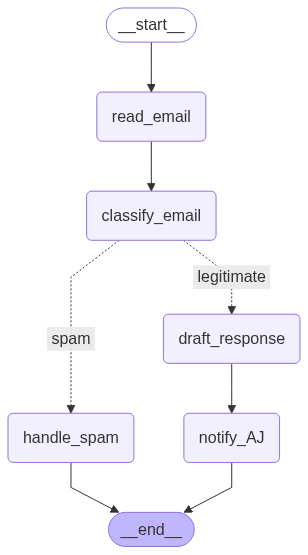

In [51]:
from IPython.display import Image, display

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

# Run the Application

In [54]:
# Example legitimate email
legitimate_email = {
    "sender": "john.smith@example.com",
    "subject": "Question about your services",
    "body": "Dear Mr. AJ, I was referred to you by a colleague and I'm interested in learning more about your consulting services. Could we schedule a call next week? Best regards, John Smith"
}

# Example spam email
spam_email = {
    "sender": "winner@lottery-intl.com",
    "subject": "YOU HAVE WON $5,000,000!!!",
    "body": "CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100."
}

# Process the legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})

# Process the spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke({
    "email":  spam_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})


Processing legitimate email...
Jarvis is processing an email from john.smith@example.com with subject: Question about your services

Sir, you've received an email from john.smith@example.com.
Subject: Question about your services
Category: inquiry

I've prepared a draft response for your review:
--------------------------------------------------
Subject: Re: Question about your services

Dear John Smith,

Thank you for reaching out and expressing interest in our consulting services. I would be happy to schedule a call with you next week to discuss how we can assist you further. Please let me know your availability so we can find a suitable time to connect.

Looking forward to our conversation.

Best regards,
AJ


Processing spam email...
Jarvis is processing an email from winner@lottery-intl.com with subject: YOU HAVE WON $5,000,000!!!
Jarvis has marked the email as spam. Reason: the email is likely a scam as it is asking for personal bank details and a processing fee in order to clai

# Inspecting Our Mail Sorting Agent with Langfuse

In [55]:
%pip install -q langfuse

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 15.4 MB/s eta 0:00:00


In [56]:
!pip install langchain

In [57]:
import os
from google.colab import userdata

# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = userdata.get('pk')
os.environ["LANGFUSE_SECRET_KEY"] = userdata.get('sk')
os.environ["LANGFUSE_HOST"] = "https://cloud.langfuse.com" # 🇪🇺 EU region
# os.environ["LANGFUSE_HOST"] = "https://us.cloud.langfuse.com" # 🇺🇸 US region

In [58]:
from langfuse.langchain import CallbackHandler

# Initialize Langfuse CallbackHandler for LangGraph/Langchain (tracing)
langfuse_handler = CallbackHandler()

In [59]:
# Process legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke(
    input={
        "email": legitimate_email,
        "is_spam": None,
        "draft_response": None,
        "messages": []
    },
    config={"callbacks": [langfuse_handler]}
)

# Process spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke(
    input={
        "email": spam_email,
        "is_spam": None,
        "draft_response": None,
        "messages": []
    },
    config={"callbacks": [langfuse_handler]}
)


Processing legitimate email...
Jarvis is processing an email from john.smith@example.com with subject: Question about your services

Sir, you've received an email from john.smith@example.com.
Subject: Question about your services
Category: inquiry

I've prepared a draft response for your review:
--------------------------------------------------
Subject: Re: Question about your services

Dear John Smith,

Thank you for reaching out and expressing interest in our consulting services. I would be happy to schedule a call with you next week to discuss how we can assist you further. Please let me know your availability so we can find a suitable time to connect.

Best regards,
AJ


Processing spam email...
Jarvis is processing an email from winner@lottery-intl.com with subject: YOU HAVE WON $5,000,000!!!
Jarvis has marked the email as spam. Reason: the email is likely a scam as it is asking for personal bank details and a processing fee in order to claim a prize. legitimate lotteries do not